# Customer Segmentation (exploration)
Pierre-Yves BOISBUNON - January 2018

------
In this notebook, we will start exploring a customer retail database.

This file is available here: https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

Tags:
- Clustering (Kmeans)
- RFM Score

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from __future__ import division
import utils

# 1. Exploration and Cleaning

Let's import the dataset first

In [2]:
df_retail = pd.read_excel('Online Retail.xlsx')
# Convert InvoiceDate as datetime variable
df_retail['InvoiceDate'] = pd.to_datetime(df_retail['InvoiceDate'])

Let's preview the dataset

In [3]:
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


If we display a static summary of the dataset we can see:
- **CustomerID** contains around 25% of missing values. Let's remove all of them.

In [4]:
# Display a column summary
stats = utils.display_dataframe_stats(df_retail)
stats

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
type,object,object,object,int64,datetime64[ns],float64,float64,object
number of unique values,25900,4070,4223,722,23260,1630,4372,38
number of missing values,0,0,1454,0,0,0,135080,0
% of missing values,0,0,0.268311,0,0,0,24.9267,0


Let's remove missing value for **CustomerID**

In [5]:
df_retail.dropna(subset=['CustomerID'], how='all', inplace=True)

Let's remove all duplicates values

In [6]:
df_retail.drop_duplicates(inplace=True)

The dataset is composed as below:

In [7]:
df_retail.shape

(401604, 8)

## 1.1 StockCode vs Description

Let's check the difference between **StockCode** and **Description** variables

In [8]:
# Collect only single tuple StockCode/Description
temp=df_retail[['StockCode','Description']].drop_duplicates()
temp=temp.groupby(['StockCode'])['Description'].count().reset_index().sort_values('Description', ascending=False)
temp[:5]

,StockCode,Description
2000,23236,4
1960,23196,4
2114,23366,3
1967,23203,3
1713,22937,3


If we observe the different description of a specific **StockCode**, we can see the changes are only related to different formulation of the same product.

In [9]:
df_retail[df_retail.StockCode == 23236]['Description'].unique()

array(['DOILEY STORAGE TIN', 'DOILEY BISCUIT TIN',
       'STORAGE TIN VINTAGE DOILY ', 'STORAGE TIN VINTAGE DOILEY '],
      dtype=object)

As it does not give a real useful information, let's drop this feature.

In [10]:
del df_retail['Description']

## 1.2 Number of customer per Country

Let's observe now, the variation of country, as the number of customers per country.

In [11]:
df_retail.Country.nunique()

37

We can see that most of customers are from:
- United Kingdom
- Germany
- France
The other country are sparsely represented.

In [12]:
customer_by_country = df_retail[['Country','CustomerID']].drop_duplicates()
customer_by_country.groupby(['Country'])['CustomerID'].count().reset_index().sort_values('CustomerID', ascending=False)[:10]

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


## 1.3 Date

The transaction variation date is between 1st of Decembre 2010 and the 9th of December 2011.

In [13]:
df_retail.InvoiceDate.describe()

count                  401604
unique                  20460
top       2011-11-14 15:27:00
freq                      543
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

## 1.4 Customer by order (InvoiceNo)

Let's observe the different transactions, now:

In [14]:
stats = df_retail.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Quantity'].count()
products = stats.rename(columns = {'Quantity':'TransactionsNo'})
products[:10].sort_values('TransactionsNo')

,CustomerID,InvoiceNo,TransactionsNo
0,12346.0,541431,1
1,12346.0,C541433,1
8,12347.0,581180,11
9,12348.0,539318,17
5,12347.0,556201,18
6,12347.0,562032,22
4,12347.0,549222,24
3,12347.0,542237,29
2,12347.0,537626,31
7,12347.0,573511,47


We can see that for customer **12346**, we can observe two transaction: transaction **514131** and **C51433**.
From the description of the dataset we know that **C** letter concerns canceled transaction.
Let's create a specific feature for canceled transaction.

In [15]:
products['CanceledNo'] = products['InvoiceNo'].apply(lambda x:int('C' in str(x)))
products[:5]

,CustomerID,InvoiceNo,TransactionsNo,CanceledNo
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


If we also observe the number of canceled transaction, we can see that around **16%** of transactions are canceled.

In [16]:
n1 = products['CanceledNo'].sum()
n2 = products.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%) 


Let's try to see if there is any specific for canceled transaction:

In [17]:
df_retail[df_retail['CustomerID'] == 12346]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom


What we see, that when a canceled transaction is detected, if comes with a previous order. Let's check if this hypotesis
is always true.

In [19]:
df_check = df_retail[df_retail.Quantity < 0][['CustomerID','StockCode','Quantity','InvoiceDate','UnitPrice']]
for index,col in df_check.iterrows():
    if df_retail[(df_retail.CustomerID == col[0]) & (df_retail.StockCode==col[1])
             & (df_retail.Quantity == -col[2])
             & (df_retail.InvoiceDate > col[3])].shape[0]==0:
        print(df_check.loc[index])
        break

CustomerID                   14527
StockCode                        D
Quantity                        -1
InvoiceDate    2010-12-01 09:41:00
UnitPrice                     27.5
Name: 141, dtype: object


This hypotesis is not checked, we can see below, that cancelation order can happen without previous order.

In [20]:
df_retail[df_retail.CustomerID == 14527][:5]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
8963,537159,22112,6,2010-12-05 13:17:00,4.95,14527.0,United Kingdom
8964,537159,22111,1,2010-12-05 13:17:00,4.95,14527.0,United Kingdom
8965,537159,21479,1,2010-12-05 13:17:00,3.75,14527.0,United Kingdom
8966,537159,22114,6,2010-12-05 13:17:00,3.95,14527.0,United Kingdom


There is no previous order (before the first date available in the dataset 1/12/2010).
Let's remove the following entries:
- The ones coming from a previous order (**entry_with_cancelation**)
- The ones without a previous order (**entry_without_cancelation**)

In [22]:
df = df_retail.copy(deep=True)
df['QuantityCanceled'] = 0
entry_with_cancelation = []
entry_without_cancelation = []

for index, col in  df_retail.iterrows():
    # Filter negative quantity
    if (col['Quantity'] > 0): continue        
    # Look for entries from the same customer ordering the same product in the past
    # - same customer ID, same StockCode
    # - previous InvoiceDate
    # - order with posive quantity
    df_test = df_retail[(df_retail['CustomerID'] == col['CustomerID']) &
                         (df_retail['StockCode']  == col['StockCode']) & 
                         (df_retail['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_retail['Quantity']   > 0)].copy()
    if (df_test.shape[0] == 0):
        # This customer has not ordered this product in the past
        # This is a refund from a non previous order => remove it!
        entry_without_cancelation.append(index)
    elif (df_test.shape[0] == 1):
        # This customer has made one order of this product in the past => remove it
        entry_with_cancelation.append(index)        
        # Compute quantity canceled based on quantity 'refunded'
        df.QuantityCanceled.loc[df_test.index[0]] = -col['Quantity']
    else:
        # This customer has made multiple orders of this product in the past
        df_test = df_test.sort_values('InvoiceDate')
        for ind, val in df_test.iterrows():
            # Look for the first quantity entries with a value above quantity 'refunded' and break
            if val['Quantity'] < -col['Quantity']: continue
            df.QuantityCanceled.loc[ind] = -col['Quantity']
            entry_with_cancelation.append(index) 
            break

We know have a list of the entries that we need to remove.

In [23]:
print("entry_with_cancelation: {}".format(len(entry_with_cancelation)))
print("entry_without_cancelation: {}".format(len(entry_without_cancelation)))

entry_with_cancelation: 7521
entry_without_cancelation: 1303


In [24]:
df.drop(entry_with_cancelation, axis=0, inplace=True)
df.drop(entry_without_cancelation, axis=0, inplace=True)

Let's compute the **TotalPrice** feature for each order based on **Quantity** ordered and **QuantityCanceled** per each order.

In [25]:
df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] - df['QuantityCanceled'])
df.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215,0.0
148288,549222,22375,4,2011-04-07 10:43:00,4.25,12347.0,Iceland,0,17.0
428969,573511,47567B,6,2011-10-31 12:25:00,5.95,12347.0,Iceland,0,35.7
428968,573511,47580,6,2011-10-31 12:25:00,2.55,12347.0,Iceland,0,15.3
428967,573511,23173,2,2011-10-31 12:25:00,9.95,12347.0,Iceland,0,19.9


In [26]:
df.shape

(392780, 9)

In [27]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34


Let's store this intermediate dataset:

In [361]:
df.to_csv('../../../../OPENCLASSROOMS/PROJET5/dataset_intermediate.csv', sep='\t', index=False, encoding='utf-8')
#df = pd.read_csv('../../../../OPENCLASSROOMS/PROJET5/dataset_intermediate.csv', sep='\t')
#df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 2. Feature Engineering

As we previously see, most of customers are located in **United Kingdom**, **Germany** or **France**, let's keep the customers only located in this country with **TotalPrice** positive.

In [28]:
df = df[(df.Country == 'United Kingdom') | (df.Country == 'Germany') | (df.Country == 'France')]
df = df[df.TotalPrice > 0]

In the next part, we will create some variables that would like to create customer segmentation.

## 2.1 RFM

The first one is **RFM** score is computed on a **1 year period** and is based on three criteria:
- Recency: number of days elapsed from last transaction.
- Frequency: number of transaction from the given period.
- Monetary Value: mean basket price.

In [29]:
import datetime as dt
NOW = dt.datetime(2011,12,10)

The last transaction date is **2011/12/10**, let's define **NOW** variable.

In [30]:
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.mean()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value'}, inplace=True)
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12413.0,66,37,18.760811
12426.0,194,30,19.424333
12427.0,21,30,23.612333
12437.0,1,199,24.606332
12441.0,366,11,15.777273


In order to define the final **RFM** score, let's create quartile for the split of **recency**, 
**frequency** and **monetary value**.

In [31]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12413.0,66,37,18.760811,3,3,2
12426.0,194,30,19.424333,4,3,2
12427.0,21,30,23.612333,2,3,2
12437.0,1,199,24.606332,1,1,1
12441.0,366,11,15.777273,4,4,3


The **RFM** score is then directly a combinaition of **r_quartile**, **f_quartile** and **m_quartile**.

In [32]:
segmented_rfm['RFMscore'] = segmented_rfm.r_quartile.map(str)\
                            + segmented_rfm.f_quartile.map(str)\
                            + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMscore
CustomerID,,,,,,,
12413.0,66,37,18.760811,3,3,2,332
12426.0,194,30,19.424333,4,3,2,432
12427.0,21,30,23.612333,2,3,2,232
12437.0,1,199,24.606332,1,1,1,111
12441.0,366,11,15.777273,4,4,3,443


## 2.2 Observe day of the week

We can also define a specific feature for each of the customer based on the day of the transaction.

In [33]:
# Create one variable per day of the week?
segmented_rfm['day_0'] = 0 # Monday
segmented_rfm['day_1'] = 0 # Tuesday
segmented_rfm['day_2'] = 0 # Wednesday
segmented_rfm['day_3'] = 0 # Thursday
segmented_rfm['day_4'] = 0 # Friday
segmented_rfm['day_5'] = 0 # Saturday
segmented_rfm['day_6'] = 0 # Sunday

In [34]:
customer_lst = df.CustomerID.unique()
for cust in customer_lst:
    df_subset = df[df.CustomerID == cust].InvoiceDate
    date_lst = pd.to_datetime(df_subset.unique().tolist())
    weekday_lst = pd.to_datetime(date_lst).weekday.tolist()
    for day in weekday_lst:
        segmented_rfm['day_' + str(day)].loc[segmented_rfm.index == cust] = 1

## 2.3 Product ordered in big quantity:

If we focus on the product, we can also create specific features for the quantity order:
- Quantity mean
- Quantity max
- Quantity min

In [35]:
# Create quantity category
segmented_rfm['qty_mean'] = 0
segmented_rfm['qty_min']  = 0
segmented_rfm['qty_max']  = 0

In [36]:
customer_lst = df.CustomerID.unique()
for cust in customer_lst:
    segmented_rfm['qty_mean'].loc[segmented_rfm.index == cust] = df[df.CustomerID == cust].Quantity.mean()
    segmented_rfm['qty_min'].loc[segmented_rfm.index == cust] = df[df.CustomerID == cust].Quantity.min()
    segmented_rfm['qty_max'].loc[segmented_rfm.index == cust] = df[df.CustomerID == cust].Quantity.max()

## 2.4 Mean product price

If we contiue, we can also create specific features for the product price related informations:

- Unit Price mean/max/min for all of the items ordered.
- Total Price mean/max/min for all of the orders.

In [37]:
# Create price category
segmented_rfm['unitprice_mean']  = 0
segmented_rfm['unitprice_max']   = 0
segmented_rfm['unitprice_min']   = 0
segmented_rfm['totalprice_mean'] = 0
segmented_rfm['totalprice_max']  = 0
segmented_rfm['totalprice_min']  = 0

In [38]:
customer_lst = df.CustomerID.unique()
for cust in customer_lst:
    segmented_rfm['unitprice_mean'].loc[segmented_rfm.index == cust] = df[df.CustomerID == cust].UnitPrice.mean()
    segmented_rfm['unitprice_max'].loc[segmented_rfm.index == cust] = df[df.CustomerID == cust].UnitPrice.min()
    segmented_rfm['unitprice_min'].loc[segmented_rfm.index == cust] = df[df.CustomerID == cust].UnitPrice.max()
    segmented_rfm['totalprice_mean'].loc[segmented_rfm.index == cust] = df[df.CustomerID == cust].TotalPrice.mean()
    segmented_rfm['totalprice_max'].loc[segmented_rfm.index == cust] = df[df.CustomerID == cust].TotalPrice.min()
    segmented_rfm['totalprice_min'].loc[segmented_rfm.index == cust] = df[df.CustomerID == cust].TotalPrice.max()

Let's store the the new dataset containing one entry for each user.

In [275]:
segmented_rfm.to_csv('../../../../OPENCLASSROOMS/PROJET5/segmented_rfm_backup2.csv', sep='\t', index=False, encoding='utf-8')
#segmented_rfm = pd.read_csv('../../../../OPENCLASSROOMS/PROJET5/segmented_rfm_backup2.csv', sep='\t')

In [39]:
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMscore,day_0,day_1,day_2,...,day_6,qty_mean,qty_min,qty_max,unitprice_mean,unitprice_max,unitprice_min,totalprice_mean,totalprice_max,totalprice_min
CustomerID,,,,,,,,,,,,,,,,,,,,,
12413.0,66,37,18.760811,3,3,2,332,0,1,0,...,1,7.648649,1,24,4.441622,0.65,29.95,18.760811,7.80,47.70
12426.0,194,30,19.424333,4,3,2,432,0,0,0,...,1,8.600000,1,25,3.936333,0.10,18.00,19.424333,2.50,72.00
12427.0,21,30,23.612333,2,3,2,232,1,0,0,...,0,8.166667,2,24,4.735000,1.25,18.00,23.612333,7.65,68.00
12437.0,1,199,24.606332,1,1,1,111,0,0,1,...,0,14.683417,1,120,4.012563,0.21,18.00,24.606332,4.68,131.40
12441.0,366,11,15.777273,4,4,3,443,0,0,1,...,0,11.000000,1,25,3.700909,0.42,18.00,15.777273,10.50,23.25


# 3 Clustering

Some variables do not need to be kept for the clustering, let's remove them.

In [40]:
segmented_rfm.drop('frequency', axis=1, inplace=True)
segmented_rfm.drop('monetary_value', axis=1, inplace=True)
segmented_rfm.drop('recency', axis=1, inplace=True)
segmented_rfm.drop('r_quartile', axis=1, inplace=True)
segmented_rfm.drop('f_quartile', axis=1, inplace=True)
segmented_rfm.drop('m_quartile', axis=1, inplace=True)

segmented_rfm.head()

,RFMscore,day_0,day_1,day_2,day_3,day_4,day_5,day_6,qty_mean,qty_min,qty_max,unitprice_mean,unitprice_max,unitprice_min,totalprice_mean,totalprice_max,totalprice_min
CustomerID,,,,,,,,,,,,,,,,,
12413.0,332,0,1,0,1,0,0,1,7.648649,1,24,4.441622,0.65,29.95,18.760811,7.80,47.70
12426.0,432,0,0,0,0,0,0,1,8.600000,1,25,3.936333,0.10,18.00,19.424333,2.50,72.00
12427.0,232,1,0,0,0,1,0,0,8.166667,2,24,4.735000,1.25,18.00,23.612333,7.65,68.00
12437.0,111,0,0,1,1,1,0,0,14.683417,1,120,4.012563,0.21,18.00,24.606332,4.68,131.40
12441.0,443,0,0,1,0,0,0,0,11.000000,1,25,3.700909,0.42,18.00,15.777273,10.50,23.25


In [43]:
from sklearn import cluster, metrics
from sklearn import preprocessing
#X_norm=preprocessing.scale(segmented_rfm)
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(segmented_rfm)

For the clustering, we will use two technicals to optimize the number of clusters:
- observe silhouette coefficients
- use elbow observation

## 3.1 Observe silhouette coefficients

For n_clusters = 4 The average silhouette_score is : 0.1549474222663417


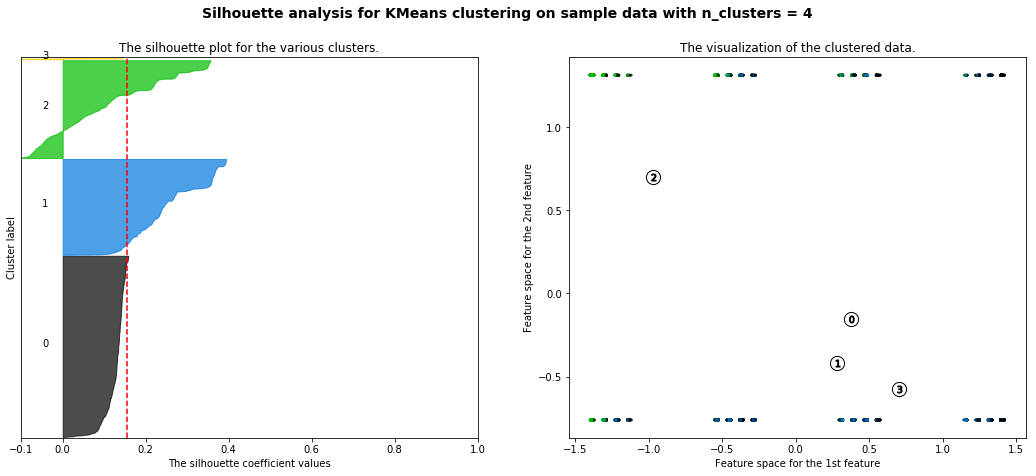

For n_clusters = 5 The average silhouette_score is : 0.1775142669713453


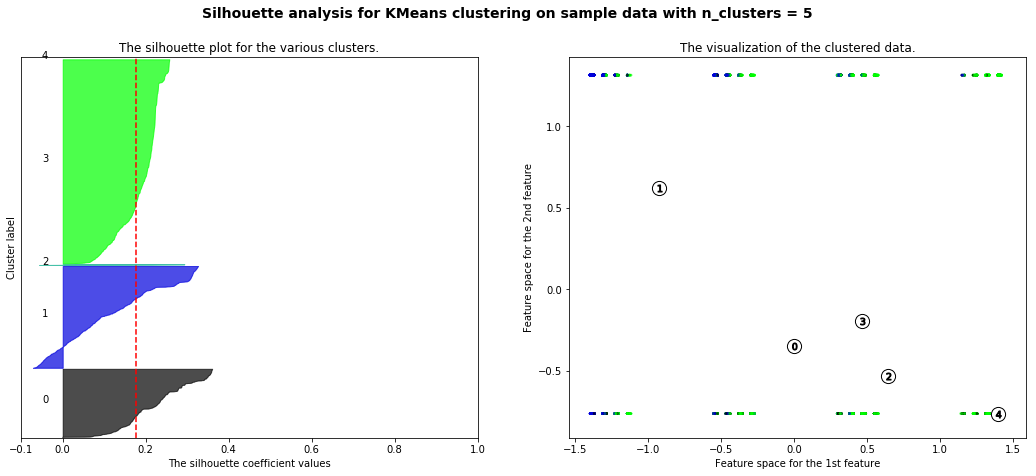

For n_clusters = 6 The average silhouette_score is : 0.16418970707585065


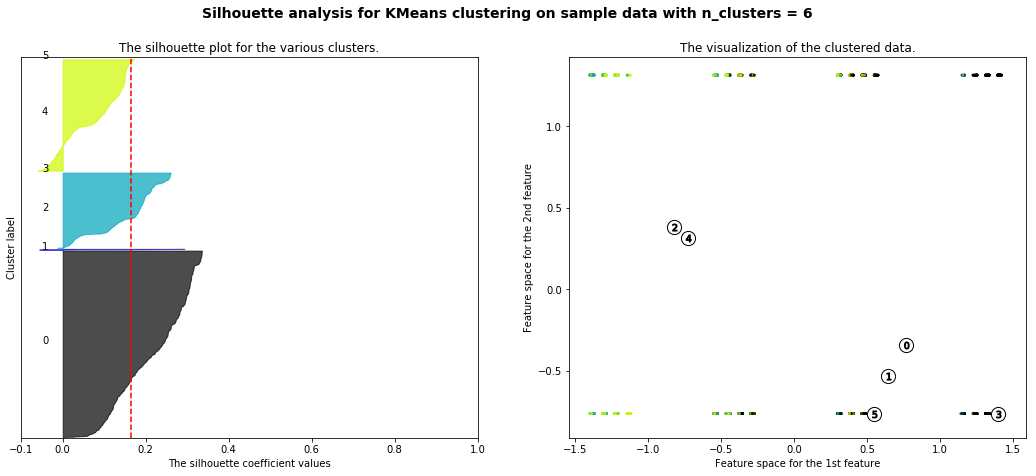

For n_clusters = 7 The average silhouette_score is : 0.17627653163832507


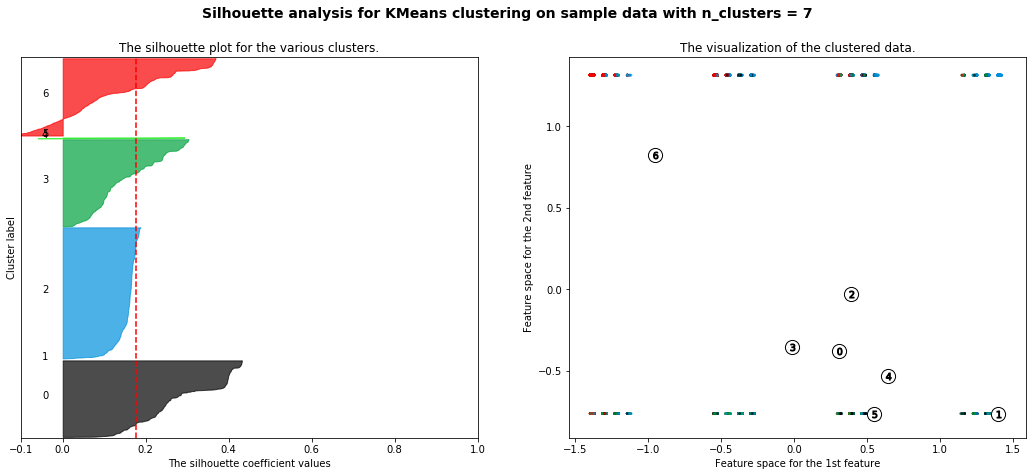

For n_clusters = 8 The average silhouette_score is : 0.1911058025447619


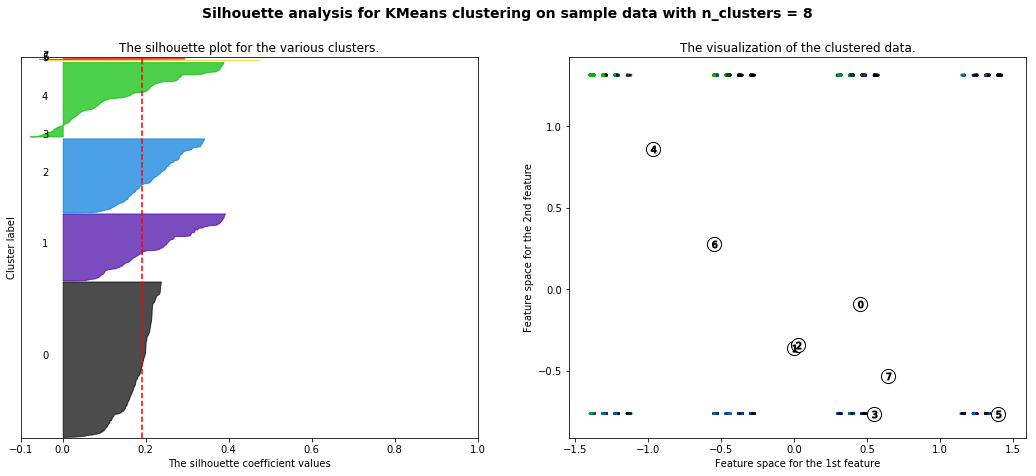

In [46]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import matplotlib.cm as cm
range_n_clusters = [4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_norm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X_norm, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_norm[:, 0], X_norm[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

For the three graph, we observe that all of the custers are above silhouette average score.
But, if we observe the thickness of the silhouette per cluster, the silhouette plot for cluster 1 when n_clusters 
is equal to 8, is bigger in size owing than for the others. Let's try to confirm this with **elbow** optimisation.

## 3.2 Elbow optimisation

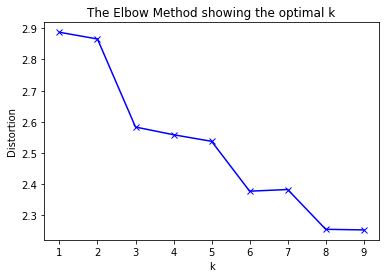

In [47]:
from scipy.spatial.distance import cdist
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k).fit(X_norm)
    kmeanModel.fit(X_norm)
    distortions.append(sum(np.min(cdist(X_norm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_norm.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

If we observe the distorsion, we can also confirm, that **n_clusters==8** seem to be the right candidate.

## 3.3 Clustering: final choice

Let's compute final clustering based on our optimal number of clusters.

In [48]:
cls7 = cluster.KMeans(n_clusters=8, n_init=100, init='k-means++')
cls7.fit(X_norm)
clusters_customers = cls7.predict(X_norm)
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['nb clients']).T

,0,5,3,7,4,6,1,2
nb clients,1385,987,882,826,9,2,1,1


Clusters 4-6-1-2 are sparsely represented. Let's remove them.

In [57]:
segmented_rfm['category'] = clusters_customers
column = [
    'day_0','day_1','day_2','day_3','day_4','day_5','day_6',
    'qty_mean','qty_min','qty_max','unitprice_mean','unitprice_max',
    'unitprice_min','totalprice_mean','totalprice_max','totalprice_min'
]
stats = pd.DataFrame(columns = ['category_0', 'category_3', 'category_5', 'category_7'])
i = 0
for col in column:
    # Append entry to the end of the DataFrame
    stats.loc[i] = [
        segmented_rfm[segmented_rfm.category == 0][col].mean(),
        segmented_rfm[segmented_rfm.category == 3][col].mean(),
        segmented_rfm[segmented_rfm.category == 5][col].mean(),
        segmented_rfm[segmented_rfm.category == 7][col].mean()
    ]
    stats = stats.rename(index={i: col})
    i = i + 1
stats

,category_0,category_3,category_5,category_7
day_0,0.354513,0.743764,0.213779,0.170702
day_1,0.335018,0.809524,0.249240,0.222760
day_2,0.000000,0.777778,1.000000,0.000000
day_3,0.000000,0.851474,0.314083,1.000000
day_4,0.319134,0.807256,0.140831,0.184019
day_5,0.000000,0.000000,0.000000,0.000000
day_6,0.303249,0.522676,0.165147,0.167070
qty_mean,15.982977,21.957100,16.961336,14.563060
qty_min,6.137906,2.628118,5.172239,4.599274
qty_max,47.075812,149.221088,62.638298,52.076271


What we can interpret:
- category 7 ('cold': small recurrence )
- category 0 ('discrete': low recurrence (without thursday and saturday))
- category 5 ('loyal': high recurrence, quantity medium)
- category 3 ('gold': high recurrence, quantity mean high)

In [58]:
segmented_rfm = segmented_rfm[
        (segmented_rfm.category == 0) |
        (segmented_rfm.category == 3) |
        (segmented_rfm.category == 5) |
        (segmented_rfm.category == 7)
]
segmented_rfm.head()

,RFMscore,day_0,day_1,day_2,day_3,day_4,day_5,day_6,qty_mean,qty_min,qty_max,unitprice_mean,unitprice_max,unitprice_min,totalprice_mean,totalprice_max,totalprice_min,category
CustomerID,,,,,,,,,,,,,,,,,,
12413.0,332,0,1,0,1,0,0,1,7.648649,1,24,4.441622,0.65,29.95,18.760811,7.80,47.70,7
12426.0,432,0,0,0,0,0,0,1,8.600000,1,25,3.936333,0.10,18.00,19.424333,2.50,72.00,0
12427.0,232,1,0,0,0,1,0,0,8.166667,2,24,4.735000,1.25,18.00,23.612333,7.65,68.00,0
12437.0,111,0,0,1,1,1,0,0,14.683417,1,120,4.012563,0.21,18.00,24.606332,4.68,131.40,3
12441.0,443,0,0,1,0,0,0,0,11.000000,1,25,3.700909,0.42,18.00,15.777273,10.50,23.25,5


If we observe, the 4 classes previously created, we can graphicaly observe their repartition.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FE8C11BFD0>],
      dtype=object)

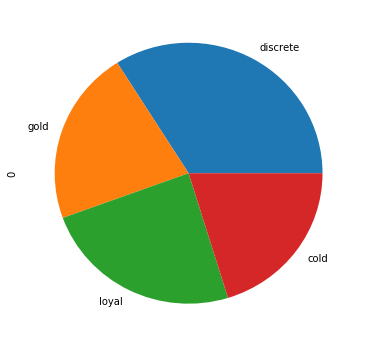

In [61]:
my_df = pd.DataFrame({'discrete':  [segmented_rfm[segmented_rfm.category == 0].shape[0]],
                      'gold':  [segmented_rfm[segmented_rfm.category == 3].shape[0]],
                      'loyal':  [segmented_rfm[segmented_rfm.category == 5].shape[0]],
                      'cold':  [segmented_rfm[segmented_rfm.category == 7].shape[0]]})
f, ax = plt.subplots(figsize=(6, 6))
my_df.iloc[0].plot.pie(subplots=True, ax=ax)

# 4. Store Final Dataset

Let's store the final dataset with the different clusters computed removing **RFM** score variable as the target is to segment customer based on their first transaction.

In [60]:
segmented_rfm.drop('RFMscore', axis=1, inplace=True)
segmented_rfm.to_csv('segmented_rfm.csv', sep='\t', index=False, encoding='utf-8')